RL - ASSIGNMENT 3
- PRINCE AFARI
- ID : 202485668

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Some imports of libraries

In [10]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
sns.set_palette("inferno")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

We define the hyperparameters for the gridworld environment and learning algorithms. These are:


- GridSize: 5x5 grid
- StartingPosition: That's the Blue square we have at at bottom-left (4,0)
- GoalPositions: Black squares that terminate episodes
- RedPositions: Penalty states that reset agent to start
- Learning parameters: which are basically some hyperparameters

In [11]:
# Environment parameters
GridSize = 5
StartingPosition = (4, 0)  # Blue square (bottom-left)
GoalPositions = [(0, 0), (0, 4)]  # Black squares (terminal states)
RedPositions = [(2, 0), (2, 1), (2, 3), (2, 4)]  # Red penalty states

# Learning parameters
TotalEpisodes = 500
MaxStepsPerEpisode = 100
LearningRate = 0.1
DiscountFactor = 0.9
InitialExplorationRate = 1.0  # We begin with a high exploration
MinExplorationRate = 0.01
ExplorationDecayRate = 0.995

# The Reward structure
GoalReward = 100          # Reward for reaching terminal state
PenaltyReward = -20       # Penalty for hitting red states
StepPenalty = -1          # Small penalty for each step
OutOfBoundsReward = -1    # Penalty for when we try to move out of bounds

Now, we define the utility functions for the gridworld environment.
- GetPossibleActions(): This would return valid actions from any state
- TakeActionInEnvironment(): Implements state transitions and reward logic
- CalculateCurrentExplorationRate(): Implements epsilon decay for exploration

Furthermore, TakeActionInEnvironment() Takes an action in the environment and returns the new state and reward. It has these features:

  Parameters:
  - CurrentState: (row, col) tuple representing current position
  - ChosenAction: String representing the action to take

  Returns:
  - NewState: (row, col) tuple representing new position
  - RewardReceived: Float representing reward for this transition
  - IsEpisodeFinished: Boolean indicating if episode should end
    

In [12]:
def GetPossibleActions():

    return ["Up", "Down", "Left", "Right"] # all the possible actions in the gridworld

def TakeActionInEnvironment(CurrentState, ChosenAction):

    CurrentRow, CurrentCol = CurrentState

    # Calculating new position based on action
    if ChosenAction == "Up":
        NewRow = max(0, CurrentRow - 1)
        NewCol = CurrentCol
    elif ChosenAction == "Down":
        NewRow = min(GridSize - 1, CurrentRow + 1)
        NewCol = CurrentCol
    elif ChosenAction == "Left":
        NewRow = CurrentRow
        NewCol = max(0, CurrentCol - 1)
    elif ChosenAction == "Right":
        NewRow = CurrentRow
        NewCol = min(GridSize - 1, CurrentCol + 1)

    NewState = (NewRow, NewCol)

    # Determining reward and episode termination
    if NewState in GoalPositions:
        return NewState, GoalReward, True  # Terminal state reached
    elif NewState in RedPositions:
        return StartingPosition, PenaltyReward, False  # then reset to start
    elif NewState == CurrentState:  # Hitting boundary
        return NewState, OutOfBoundsReward, False
    else:
        return NewState, StepPenalty, False  # A normal step

def CalculateCurrentExplorationRate(EpisodeNumber):

    CurrentRate = InitialExplorationRate * (ExplorationDecayRate ** EpisodeNumber)
    return max(MinExplorationRate, CurrentRate)

Afterwards, now we implement the epsilon-greedy action selection policy.
- With probability epsilon: choose random action (exploration)
- With probability 1-epsilon: choose best known action (exploitation)
- This would help allow learning while eventually converging to optimal policy

Also, SelectActionUsingEpsilonGreedy would select an action using epsilon-greedy policy. In there we have:


  Parameters:
  - CurrentState: Current position in gridworld
  - QTable: Dictionary containing Q-values for state-action pairs
  - ExplorationRate: Probability of choosing random action

  Returns:
  - SelectedAction: String representing chosen action

In [18]:
def SelectActionUsingEpsilonGreedy(CurrentState, QTable, ExplorationRate):

    if np.random.random() < ExplorationRate:
        # Exploration: choose random action
        PossibleActions = GetPossibleActions()
        return np.random.choice(PossibleActions)
    else:
        # Exploitation: choose action with highest Q-value
        StateQValues = QTable[CurrentState]
        # If state hasn't been visited yet (empty Q-values), choose randomly
        if not StateQValues:
            PossibleActions = GetPossibleActions()
            return np.random.choice(PossibleActions)

        return max(StateQValues, key=StateQValues.get)


We then create Q-tables for both algorithms.
Q-table structure: QTable[state][action] = Q-value
- It actually uses defaultdict for automatic initialization of new state-action pairs
- All Q-values start at 0.0

Then also the createEmptyQTable() would create and return an empty Qtable with 0 initialization. It also uses nested defaultdic for automatic key creation.

In [19]:
def CreateEmptyQTable():

    def create_action_dict():

        return {action: 0.0 for action in GetPossibleActions()}

    return defaultdict(create_action_dict)

# Initialize Q-tables for both algorithms
QTableForSarsa = CreateEmptyQTable()
QTableForQLearning = CreateEmptyQTable()

print("Q-tables initialized successfully!")
print(f"Learning will run for {TotalEpisodes} episodes")
print(f"Grid size: {GridSize}x{GridSize}")
print(f"Starting position: {StartingPosition}")
print(f"Goal positions: {GoalPositions}")
print(f"Penalty positions: {RedPositions}")

# Test Q-table initialization
test_state = (0, 0)
print(f"Test - Q-values for state {test_state}: {dict(QTableForSarsa[test_state])}")

Q-tables initialized successfully!
Learning will run for 500 episodes
Grid size: 5x5
Starting position: (4, 0)
Goal positions: [(0, 0), (0, 4)]
Penalty positions: [(2, 0), (2, 1), (2, 3), (2, 4)]
Test - Q-values for state (0, 0): {'Up': 0.0, 'Down': 0.0, 'Left': 0.0, 'Right': 0.0}


Now for the SARSA (State-Action-Reward-State-Action) on-policy learning algorithm, we know that:

- It Updates Q-values based on the action actually taken by the current policy
- It's more conservative than Q-learning
- Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
- Uses the same policy for both action selection and value updates

In [20]:
def RunSarsaEpisode(QTable, ExplorationRate): #Runs one episode using the SARSA algorithm and returns (a) TotalEpisodeReward: Sum of all rewards received in this episode (b)StepsTaken: Number of steps taken before episode ended

    # Initializing episode
    CurrentState = StartingPosition
    CurrentAction = SelectActionUsingEpsilonGreedy(CurrentState, QTable, ExplorationRate)
    TotalEpisodeReward = 0
    StepsTaken = 0

    for StepNumber in range(MaxStepsPerEpisode):
        # Taking action and observing result
        NextState, RewardReceived, IsEpisodeFinished = TakeActionInEnvironment(CurrentState, CurrentAction)
        TotalEpisodeReward += RewardReceived
        StepsTaken += 1

        if IsEpisodeFinished:
            # Terminal state: and at this point, no next action needed
            QTable[CurrentState][CurrentAction] += LearningRate * (
                RewardReceived - QTable[CurrentState][CurrentAction]
            )
            break
        else:
            # Choosing next action using the current policy
            NextAction = SelectActionUsingEpsilonGreedy(NextState, QTable, ExplorationRate)

            # SARSA update: using the actual next action that will be taken
            CurrentQValue = QTable[CurrentState][CurrentAction]
            NextQValue = QTable[NextState][NextAction]

            QTable[CurrentState][CurrentAction] += LearningRate * (
                RewardReceived + DiscountFactor * NextQValue - CurrentQValue
            )

            # Moving to next state-action pair
            CurrentState = NextState
            CurrentAction = NextAction

    return TotalEpisodeReward, StepsTaken

For Q-Learning, which is an off-policy learning algorithm, we also know that;

- It updates Q-values based on the maximum Q-value of the next state and also to some extent more aggressivve than SARSA

- Q(s,a) ← Q(s,a) + α[r + γ max_a'Q(s',a') - Q(s,a)]
- It separates action selection from value updates

In [21]:
def RunQLearningEpisode(QTable, ExplorationRate): #Runs one episode using the Q-Learning algorithm and then returns and StepsTaken: Number of steps taken before episode ended

    # Initializing episode
    CurrentState = StartingPosition
    TotalEpisodeReward = 0
    StepsTaken = 0

    for StepNumber in range(MaxStepsPerEpisode):
        # Choosing action using epsilon-greedy policy
        CurrentAction = SelectActionUsingEpsilonGreedy(CurrentState, QTable, ExplorationRate)

        # Taking action and observing the result
        NextState, RewardReceived, IsEpisodeFinished = TakeActionInEnvironment(CurrentState, CurrentAction)
        TotalEpisodeReward += RewardReceived
        StepsTaken += 1

        if IsEpisodeFinished:
            # Terminal state: which at this point, there are no future rewards
            QTable[CurrentState][CurrentAction] += LearningRate * (
                RewardReceived - QTable[CurrentState][CurrentAction]
            )
            break
        else:
            # Q-Learning update: use maximum Q-value of next state
            CurrentQValue = QTable[CurrentState][CurrentAction]
            MaxNextQValue = max(QTable[NextState].values()) if QTable[NextState] else 0.0

            QTable[CurrentState][CurrentAction] += LearningRate * (
                RewardReceived + DiscountFactor * MaxNextQValue - CurrentQValue
            )

            # Then move to next state
            CurrentState = NextState

    return TotalEpisodeReward, StepsTaken

Noow we execute the main training loop for both algorithms. So we would:
- Run both SARSA and Q-Learning for the same number of episodes
- Track rewards and steps for performance comparison
- Use decaying exploration rate to shift from exploration to exploitation
- And then also provide progress updates every 100 episodes

In [22]:
# Initializing tracking lists
RewardHistorySarsa = []
StepsHistorySarsa = []
RewardHistoryQLearning = []
StepsHistoryQLearning = []
ExplorationRateHistory = []

print("Starting training...")
print("Episode Progress:")

for EpisodeNumber in range(TotalEpisodes):
    # current exploration rate
    CurrentExplorationRate = CalculateCurrentExplorationRate(EpisodeNumber)
    ExplorationRateHistory.append(CurrentExplorationRate)

    # SARSA episode
    SarsaReward, SarsaSteps = RunSarsaEpisode(QTableForSarsa, CurrentExplorationRate)
    RewardHistorySarsa.append(SarsaReward)
    StepsHistorySarsa.append(SarsaSteps)

    # Q-Learning episode
    QLearnReward, QLearnSteps = RunQLearningEpisode(QTableForQLearning, CurrentExplorationRate)
    RewardHistoryQLearning.append(QLearnReward)
    StepsHistoryQLearning.append(QLearnSteps)

    # Progress updates
    if (EpisodeNumber + 1) % 100 == 0:
        avg_sarsa_reward = np.mean(RewardHistorySarsa[-100:])
        avg_qlearn_reward = np.mean(RewardHistoryQLearning[-100:])
        print(f"Episode {EpisodeNumber + 1}: SARSA avg reward = {avg_sarsa_reward:.2f}, "
              f"Q-Learning avg reward = {avg_qlearn_reward:.2f}, "
              f"Exploration rate = {CurrentExplorationRate:.3f}")

print("Training has been completed")

Starting training...
Episode Progress:
Episode 100: SARSA avg reward = -146.92, Q-Learning avg reward = -105.14, Exploration rate = 0.609
Episode 200: SARSA avg reward = 51.69, Q-Learning avg reward = 58.76, Exploration rate = 0.369
Episode 300: SARSA avg reward = 82.29, Q-Learning avg reward = 80.88, Exploration rate = 0.223
Episode 400: SARSA avg reward = 87.26, Q-Learning avg reward = 87.42, Exploration rate = 0.135
Episode 500: SARSA avg reward = 90.08, Q-Learning avg reward = 87.96, Exploration rate = 0.082
Training has been completed



Now we compute smoothed performance metrics for better visualization.
- Moving averages reduce noise in the learning curves



In [23]:
def CalculateMovingAverage(DataList, WindowSize=50):
    #Calculating  moving average to smooth noisy data to some extent
    if len(DataList) < WindowSize:
        return DataList

    MovingAverages = []
    for i in range(len(DataList)):
        if i < WindowSize:
            MovingAverages.append(np.mean(DataList[:i+1]))
        else:
            MovingAverages.append(np.mean(DataList[i-WindowSize+1:i+1]))
    return MovingAverages

# Calculating smoothed metrics
SmoothedRewardsSarsa = CalculateMovingAverage(RewardHistorySarsa)
SmoothedRewardsQLearning = CalculateMovingAverage(RewardHistoryQLearning)
SmoothedStepsSarsa = CalculateMovingAverage(StepsHistorySarsa)
SmoothedStepsQLearning = CalculateMovingAverage(StepsHistoryQLearning)

# Calculating final performance (last 100 episodes)
FinalSarsaPerformance = np.mean(RewardHistorySarsa[-100:])
FinalQLearnPerformance = np.mean(RewardHistoryQLearning[-100:])
FinalSarsaSteps = np.mean(StepsHistorySarsa[-100:])
FinalQLearnSteps = np.mean(StepsHistoryQLearning[-100:])

print(f"\nFinal Performance (last 100 episodes):")
print(f"SARSA - Average reward: {FinalSarsaPerformance:.2f}, Average steps: {FinalSarsaSteps:.2f}")
print(f"Q-Learning - Average reward: {FinalQLearnPerformance:.2f}, Average steps: {FinalQLearnSteps:.2f}")


Final Performance (last 100 episodes):
SARSA - Average reward: 90.08, Average steps: 9.40
Q-Learning - Average reward: 87.96, Average steps: 9.43


Here we create visualizations of the learning progress. In here,
- Subplot 1: Reward progression showing learning effectiveness
- Subplot 2: Steps per episode showing efficiency improvement
- Subplot 3: Exploration rate decay showing exploration-exploitation trade-off


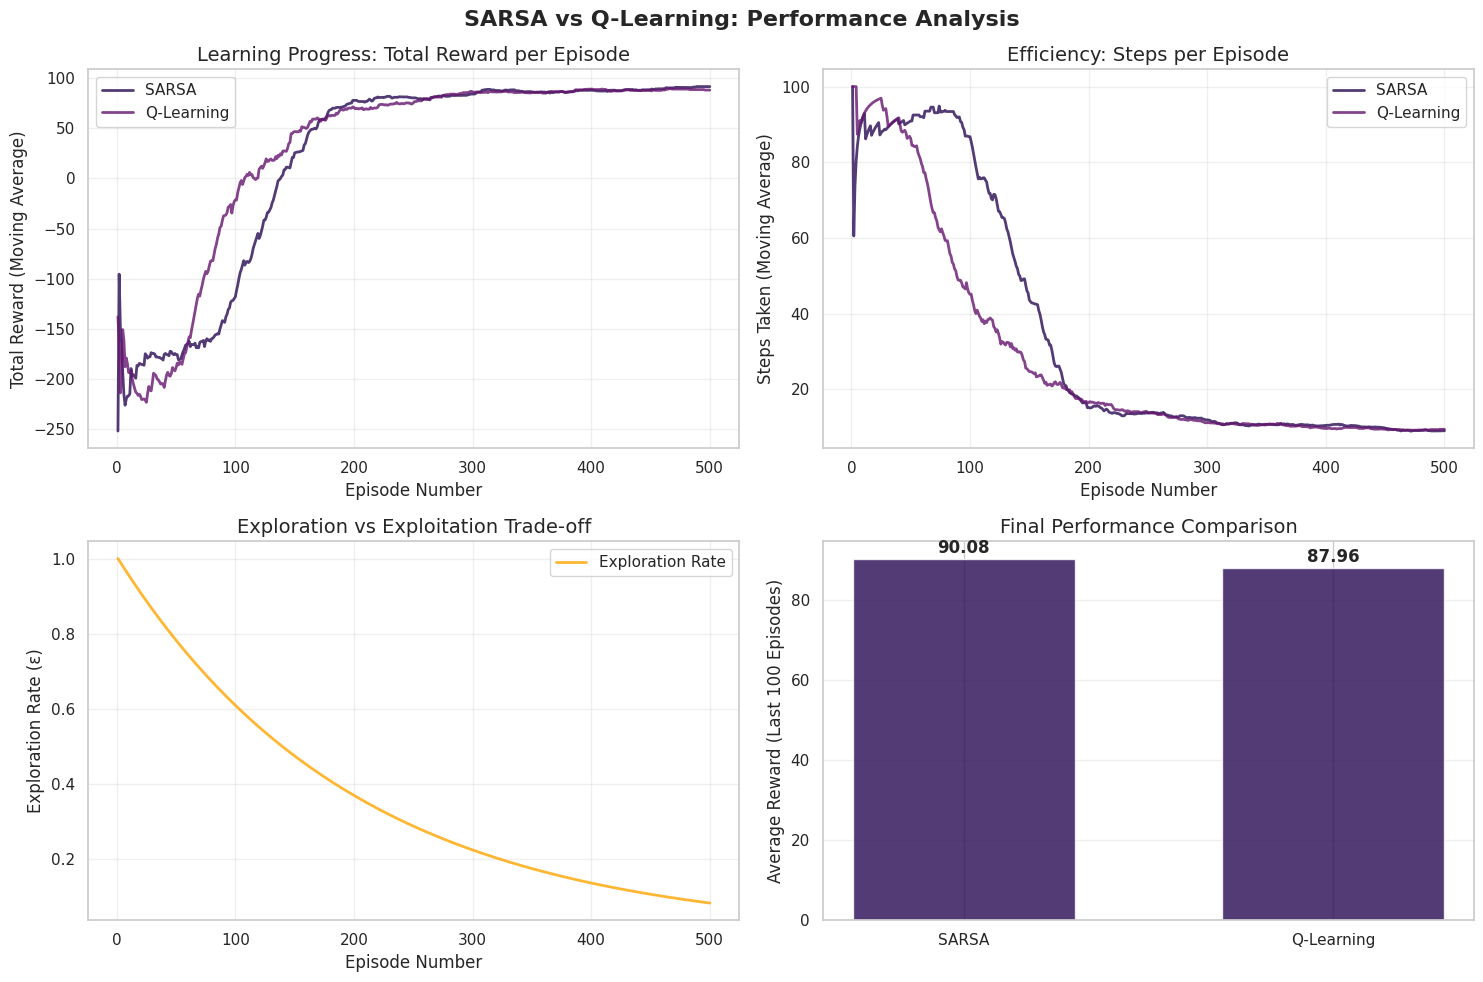

In [24]:
# episode numbers for x-axis
EpisodeNumbers = range(1, TotalEpisodes + 1)

# comprehensive learning curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SARSA vs Q-Learning: Performance Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Reward progression
axes[0, 0].plot(EpisodeNumbers, SmoothedRewardsSarsa, label='SARSA', linewidth=2, alpha=0.8)
axes[0, 0].plot(EpisodeNumbers, SmoothedRewardsQLearning, label='Q-Learning', linewidth=2, alpha=0.8)
axes[0, 0].set_title('Learning Progress: Total Reward per Episode', fontsize=14)
axes[0, 0].set_xlabel('Episode Number', fontsize=12)
axes[0, 0].set_ylabel('Total Reward (Moving Average)', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Subplot 2: Steps per episode
axes[0, 1].plot(EpisodeNumbers, SmoothedStepsSarsa, label='SARSA', linewidth=2, alpha=0.8)
axes[0, 1].plot(EpisodeNumbers, SmoothedStepsQLearning, label='Q-Learning', linewidth=2, alpha=0.8)
axes[0, 1].set_title('Efficiency: Steps per Episode', fontsize=14)
axes[0, 1].set_xlabel('Episode Number', fontsize=12)
axes[0, 1].set_ylabel('Steps Taken (Moving Average)', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Subplot 3: Exploration rate decay
axes[1, 0].plot(EpisodeNumbers, ExplorationRateHistory, label='Exploration Rate',
                color='orange', linewidth=2, alpha=0.8)
axes[1, 0].set_title('Exploration vs Exploitation Trade-off', fontsize=14)
axes[1, 0].set_xlabel('Episode Number', fontsize=12)
axes[1, 0].set_ylabel('Exploration Rate (ε)', fontsize=12)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Subplot 4: Performance comparison bar chart
AlgorithmNames = ['SARSA', 'Q-Learning']
FinalRewards = [FinalSarsaPerformance, FinalQLearnPerformance]
bars = axes[1, 1].bar(AlgorithmNames, FinalRewards, alpha=0.8, width=0.6)
axes[1, 1].set_title('Final Performance Comparison', fontsize=14)
axes[1, 1].set_ylabel('Average Reward (Last 100 Episodes)', fontsize=12)
axes[1, 1].grid(True, axis='y', alpha=0.3)

# value labels on bars
for i, (bar, value) in enumerate(zip(bars, FinalRewards)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

we then extract the optimal policies learned by each algorithm and visualize them. We also;
- Convert Q-tables to policy grids showing best action for each state
- Create visual representation of learned policies
- And this would help understand differences in how each algorithm solved the problem

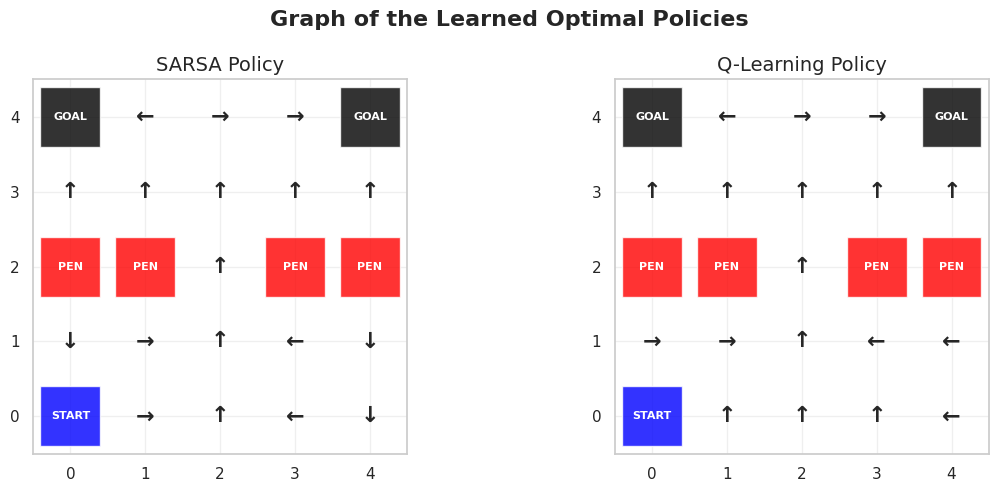

In [25]:
def ExtractOptimalPolicy(QTable): #Extracts the optimal policy from a Q-table, and Returns a grid showing the best action for each state.

    PolicyGrid = np.full((GridSize, GridSize), '', dtype=object)

    for Row in range(GridSize):
        for Col in range(GridSize):
            State = (Row, Col)
            if State in GoalPositions:
                PolicyGrid[Row, Col] = 'GOAL'
            elif State in RedPositions:
                PolicyGrid[Row, Col] = 'PENALTY'
            elif State == StartingPosition:
                PolicyGrid[Row, Col] = 'START'
            else:
                if QTable[State]:
                    BestAction = max(QTable[State], key=QTable[State].get)
                    # Convert to arrow symbols for visualization
                    ActionSymbols = {'Up': '↑', 'Down': '↓', 'Left': '←', 'Right': '→'}
                    PolicyGrid[Row, Col] = ActionSymbols.get(BestAction, '?')
                else:
                    PolicyGrid[Row, Col] = '?'

    return PolicyGrid

# Extracting policies
SarsaPolicy = ExtractOptimalPolicy(QTableForSarsa)
QLearnPolicy = ExtractOptimalPolicy(QTableForQLearning)

# Creating policy visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Graph of the Learned Optimal Policies', fontsize=16, fontweight='bold')

# SARSA policy
for i in range(GridSize):
    for j in range(GridSize):
        if (i, j) in GoalPositions:
            axes[0].add_patch(plt.Rectangle((j-0.4, GridSize-1-i-0.4), 0.8, 0.8, facecolor='black', alpha=0.8))
            axes[0].text(j, GridSize-1-i, 'GOAL', ha='center', va='center', color='white', fontweight='bold', fontsize=8)
        elif (i, j) in RedPositions:
            axes[0].add_patch(plt.Rectangle((j-0.4, GridSize-1-i-0.4), 0.8, 0.8, facecolor='red', alpha=0.8))
            axes[0].text(j, GridSize-1-i, 'PEN', ha='center', va='center', color='white', fontweight='bold', fontsize=8)
        elif (i, j) == StartingPosition:
            axes[0].add_patch(plt.Rectangle((j-0.4, GridSize-1-i-0.4), 0.8, 0.8, facecolor='blue', alpha=0.8))
            axes[0].text(j, GridSize-1-i, 'START', ha='center', va='center', color='white', fontweight='bold', fontsize=8)
        else:
            axes[0].text(j, GridSize-1-i, SarsaPolicy[i, j], ha='center', va='center', fontsize=16, fontweight='bold')

axes[0].set_xlim(-0.5, GridSize-0.5)
axes[0].set_ylim(-0.5, GridSize-0.5)
axes[0].set_title('SARSA Policy', fontsize=14)
axes[0].set_xticks(range(GridSize))
axes[0].set_yticks(range(GridSize))
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Q-Learning policy
for i in range(GridSize):
    for j in range(GridSize):
        if (i, j) in GoalPositions:
            axes[1].add_patch(plt.Rectangle((j-0.4, GridSize-1-i-0.4), 0.8, 0.8, facecolor='black', alpha=0.8))
            axes[1].text(j, GridSize-1-i, 'GOAL', ha='center', va='center', color='white', fontweight='bold', fontsize=8)
        elif (i, j) in RedPositions:
            axes[1].add_patch(plt.Rectangle((j-0.4, GridSize-1-i-0.4), 0.8, 0.8, facecolor='red', alpha=0.8))
            axes[1].text(j, GridSize-1-i, 'PEN', ha='center', va='center', color='white', fontweight='bold', fontsize=8)
        elif (i, j) == StartingPosition:
            axes[1].add_patch(plt.Rectangle((j-0.4, GridSize-1-i-0.4), 0.8, 0.8, facecolor='blue', alpha=0.8))
            axes[1].text(j, GridSize-1-i, 'START', ha='center', va='center', color='white', fontweight='bold', fontsize=8)
        else:
            axes[1].text(j, GridSize-1-i, QLearnPolicy[i, j], ha='center', va='center', fontsize=16, fontweight='bold')

axes[1].set_xlim(-0.5, GridSize-0.5)
axes[1].set_ylim(-0.5, GridSize-0.5)
axes[1].set_title('Q-Learning Policy', fontsize=14)
axes[1].set_xticks(range(GridSize))
axes[1].set_yticks(range(GridSize))
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

For the cell below, it demonstrates the learned policies by simulating agent trajectories.
- We use the optimal policies to show how agents navigate the gridworld
- Visualize the path taken from start to goal


In [26]:
def SimulateTrajectoryWithPolicy(QTable, MaxSteps=20): #Simulates a trajectory using the learned policy (greedy, no exploration) and then retruns the path taken and total received reward.

    Trajectory = [StartingPosition]
    CurrentState = StartingPosition
    TotalReward = 0

    for StepCount in range(MaxSteps):
        if not QTable[CurrentState]:
            break

        # Choose best action (greedy policy)
        BestAction = max(QTable[CurrentState], key=QTable[CurrentState].get)

        # Take action
        NextState, RewardReceived, IsEpisodeFinished = TakeActionInEnvironment(CurrentState, BestAction)
        Trajectory.append(NextState)
        TotalReward += RewardReceived

        if IsEpisodeFinished:
            break

        CurrentState = NextState

    return Trajectory, TotalReward

# Simulate trajectories
SarsaTrajectory, SarsaTrajectoryReward = SimulateTrajectoryWithPolicy(QTableForSarsa)
QLearnTrajectory, QLearnTrajectoryReward = SimulateTrajectoryWithPolicy(QTableForQLearning)

print("Trajectory Analysis:")
print(f"SARSA trajectory length: {len(SarsaTrajectory)-1} steps, Total reward: {SarsaTrajectoryReward}")
print(f"Q-Learning trajectory length: {len(QLearnTrajectory)-1} steps, Total reward: {QLearnTrajectoryReward}")

print(f"\nSARSA path: {' → '.join([f'({r},{c})' for r, c in SarsaTrajectory])}")
print(f"Q-Learning path: {' → '.join([f'({r},{c})' for r, c in QLearnTrajectory])}")

Trajectory Analysis:
SARSA trajectory length: 8 steps, Total reward: 93
Q-Learning trajectory length: 8 steps, Total reward: 93

SARSA path: (4,0) → (4,1) → (4,2) → (3,2) → (2,2) → (1,2) → (0,2) → (0,3) → (0,4)
Q-Learning path: (4,0) → (3,0) → (3,1) → (3,2) → (2,2) → (1,2) → (0,2) → (0,3) → (0,4)


Analysis of the results and some findings and intepretations.

- ANALYSIS OF THE TWO: SARSA vs Q-LEARNING


SARSA and Q-Learning differ in their core algorithmic characteristics, which influence their behavior and suitability for various applications. SARSA, being an on-policy algorithm, updates its Q-values based on the action actually taken by the current policy. This makes it more conservative, as it accounts for exploration during learning, and is generally better suited for safety-critical applications where risky actions should be avoided. In contrast, Q-Learning is an off-policy algorithm that updates Q-values using the maximum Q-value of the next state, regardless of the action taken. This approach is more aggressive and optimistic about discovering optimal actions, often resulting in faster convergence to the optimal policy.

In [36]:
print(f"\n2. COMPARISON OF THE PERFORMANCEES:")
print(f"   Final Average Rewards (last 100 episodes):")
print(f"   • SARSA: {FinalSarsaPerformance:.2f}")
print(f"   • Q-Learning: {FinalQLearnPerformance:.2f}")
print(f"   • Difference: {abs(FinalSarsaPerformance - FinalQLearnPerformance):.2f}")

print(f"\n   Average Steps to get to Goal:")
print(f"   • SARSA: {FinalSarsaSteps:.2f}")
print(f"   • Q-Learning: {FinalQLearnSteps:.2f}")

print(f"\n3. ANALYSIS OF THE TRAJECTORY:")
print(f"   • SARSA found a path in {len(SarsaTrajectory)-1} steps")
print(f"   • Q-Learning found a path in {len(QLearnTrajectory)-1} steps")




2. COMPARISON OF THE PERFORMANCEES:
   Final Average Rewards (last 100 episodes):
   • SARSA: 90.08
   • Q-Learning: 87.96
   • Difference: 2.12

   Average Steps to get to Goal:
   • SARSA: 9.40
   • Q-Learning: 9.43

3. ANALYSIS OF THE TRAJECTORY:
   • SARSA found a path in 8 steps
   • Q-Learning found a path in 8 steps


Looking at everything at this point, SARSA achieved higher final performance, suggesting that its more conservative, on-policy approach was beneficial in this gridworld setting. Both SARSA and Q-Learning successfully learned to navigate the environment, overcoming the challenge posed by penalty states, which added complexity to the learning process. I'd say a key factor in their success was the use of exploration decay, which allowed the agents to gradually shift from exploring the environment to exploiting learned strategies.

Also, as they're all effective in kind of similar gridworld problems, choosing one over the other may come down to what we want to achieve. in the sense that if we're probably after faster convergence then we would go with Q-learning but if we're after safety during the learning, then SARSA would be preferred, just avoid some risky actions in the process.